## Dependencies

In [1]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw, Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import kagglehub
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
from google.colab import drive
import re
import os


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
AUTO = tf.data.AUTOTUNE

# Model parameters

In [4]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 30
TRANSFORMER_BLOCKS = 4
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

# Load data

In [5]:
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/MyDrive/Digital Signal/Data/'

MONET_FILENAMES = tf.io.gfile.glob(os.path.join(DATASET_PATH, 'monet_jpg', '*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(DATASET_PATH, 'photo_jpg', '*.jpg'))

print(f'Monet files: {len(MONET_FILENAMES)}')
print(f'Photo files: {len(PHOTO_FILENAMES)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Monet files: 300
Photo files: 7038


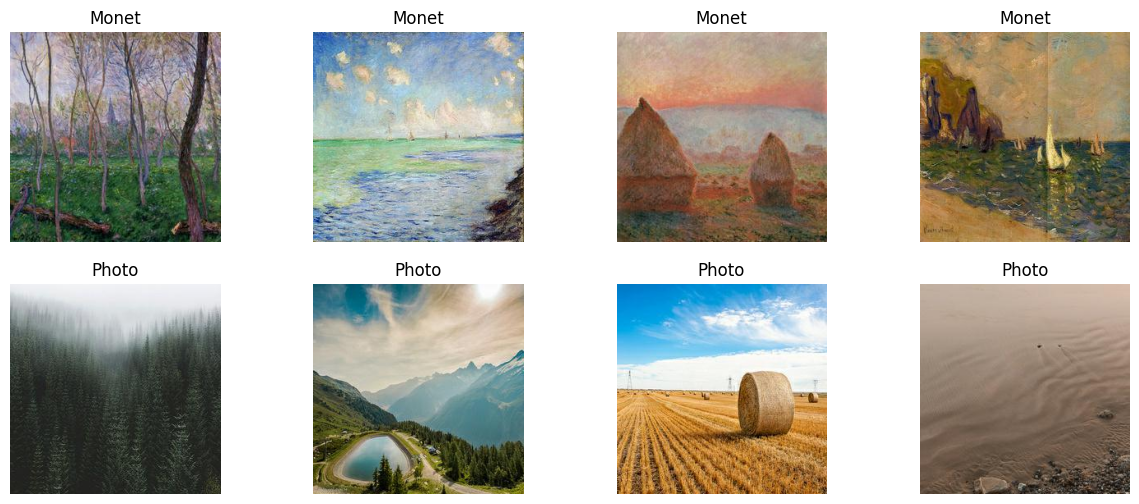

In [6]:
num_images = 4

monet_samples = MONET_FILENAMES[:num_images]
photo_samples = PHOTO_FILENAMES[:num_images]

fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

for i, img_path in enumerate(monet_samples):
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Monet")
    axes[0, i].axis("off")

for i, img_path in enumerate(photo_samples):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Photo")
    axes[1, i].axis("off")

plt.show()

In [7]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)


#     # Random jitter
#     image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

#     # Crops
#     if p_crop > .6: # random crop
#         crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
#     elif p_crop > .2: # central crop
#         if p_crop > .5:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         elif p_crop > .35:
#             image = tf.image.central_crop(image, central_fraction=.8)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.9)

    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])


    return image

In [8]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def load_jpg_images(image_paths):
    images = []

    for img_path in image_paths:
        image = tf.io.read_file(img_path)  # Read file
        image = tf.image.decode_jpeg(image, channels=3)  # Decode JPG
        image = tf.image.resize(image, [256, 256])  # Resize if necessary
        image = normalize_img(image)  # Normalize to [-1, 1]
        image = data_augment(image)  # Apply data augmentation
        images.append(image.numpy())  # Convert to NumPy array

    return np.array(images, dtype=np.float32)

In [9]:
monet_images = load_jpg_images(MONET_FILENAMES)
photo_images = load_jpg_images(PHOTO_FILENAMES[:500])

print(f"Monet dataset shape: {monet_images.shape}")
print(f"Photo dataset shape: {photo_images.shape}")

Monet dataset shape: (300, 128, 128, 3)
Photo dataset shape: (500, 128, 128, 3)


In [10]:
def create_dataset(images, batch_size=1, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(images)

    if shuffle:
        dataset = dataset.shuffle(len(images))

    dataset = dataset.batch(batch_size)

    return dataset

monet_dataset = create_dataset(monet_images, batch_size=BATCH_SIZE)
photo_dataset = create_dataset(photo_images, batch_size=BATCH_SIZE)

gan_ds = tf.data.Dataset.zip((monet_dataset, photo_dataset))

In [11]:
photo_ds_eval = create_dataset(photo_images, batch_size=1, shuffle=False)
monet_ds_eval = create_dataset(monet_images, batch_size=1, shuffle=False)

In [12]:
for monet_batch, photo_batch in gan_ds.take(1):
    print("Monet batch shape:", monet_batch.shape)
    print("Photo batch shape:", photo_batch.shape)

Monet batch shape: (16, 128, 128, 3)
Photo batch shape: (16, 128, 128, 3)


# Augmentations

Data augmentation for GANs should be done very carefully, especially for tasks similar to style transfer, if we apply transformations that can change too much the style of the data (e.g. brightness, contrast, saturation) it can cause the generator to do not efficiently learn the base style, so in this case, we are using only spatial transformations like, flips, rotates and crops.

In [13]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)


#     # Random jitter
#     image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

#     # Crops
#     if p_crop > .6: # random crop
#         crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
#     elif p_crop > .2: # central crop
#         if p_crop > .5:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         elif p_crop > .35:
#             image = tf.image.central_crop(image, central_fraction=.8)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.9)

    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])


    return image

## Auxiliar functions

In [14]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
        print(dataset)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(128)

    dataset = dataset.batch(batch_size)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)

    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)

        f = plt.figure(figsize=(12, 12))

        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()

    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)

        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')

        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')

        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')

    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

## Auxiliar functions (model)

Here we the building blocks of our models:
- Encoder block: Apply convolutional filters while also reducing data resolution and increasing features.
- Decoder block: Apply convolutional filters while also increasing data resolution and decreasing features.
- Transformer block: Apply convolutional filters to find relevant data patterns and keeps features constant.

In [15]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tf.keras.layers.LayerNormalization(gamma_initializer=gamma_initializer)(block)

    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]

    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)

    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tf.keras.layers.LayerNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)

    return block


In [16]:
DATASET_PATH = '/content/drive/MyDrive/Digital Signal/Data/'

MONET_FILENAMES = tf.io.gfile.glob(os.path.join(DATASET_PATH, 'monet_tfrec', 'monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(DATASET_PATH, 'photo_tfrec', 'photo*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\." ).search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


# Generator model

The `generator` is responsible for generating images from a specific domain. `CycleGAN` architecture has two generators, in this context we will have one `generator` that will take `photos` and generate `Monet paints`, and the other `generator` will take `Monet paintings` and generate `photos`.

Below, we have the architecture of the original `CycleGAN` `generator`, ours have some changes to improve performance on this task.

<center><img src='https://github.com/dimitreOliveira/MachineLearning/blob/master/Kaggle/I%E2%80%99m%20Something%20of%20a%20Painter%20Myself/generator_architecture.png?raw=true' height=250></center>

In [17]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)

    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection

    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection

    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)

    return generator

sample_generator = generator_fn()
sample_generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1 (Conv2D)  │ (None, 256, 256, 64)   │          9,408 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ encoder_block_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_2 (Conv2D)  │ (None, 128, 128, 128)  │         73,728 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 128, 128)  │            256 │ encoder_block_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_3 (Conv2D)  │ (None, 64, 64, 256)    │        294,912 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64, 256)    │            512 │ encoder_block_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 256)    │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_1_1     │ (None, 64, 64, 256)    │        589,824 │ re_lu_3[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 64, 64, 256)    │              0 │ transformer_block_1_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_1_2     │ (None, 64, 64, 256)    │        589,824 │ re_lu_4[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ transformer_block_1_2… │
│                           │                        │                │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_2_1     │ (None, 64, 64, 256)    │        589,824 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 64, 64, 256)    │              0 │ transformer_block_2_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_2_2     │ (None, 64, 64, 256)    │        589,824 │ re_lu_5[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 8,213,184 (31.33 MB)

 Trainable params: 8,213,184 (31.33 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator model


The `discriminator` is responsible for differentiating real images from images that have been generated by a `generator` model.

Bellow, we have the architecture of the original `CycleGAN` `discriminator`, again, ours have some changes to improve performance on this task.

<center><img src='https://github.com/dimitreOliveira/MachineLearning/blob/master/Kaggle/I%E2%80%99m%20Something%20of%20a%20Painter%20Myself/discriminator_architecture.png?raw=true' height=550, width=550></center>

In [18]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)

    discriminator = Model(inputs, outputs)

    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_1 (Conv2D)             │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_2 (Conv2D)             │ (None, 64, 64, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 64, 64, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_3 (Conv2D)             │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, 32, 32, 256)         │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_4 (Conv2D)             │ (None, 32, 32, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_6                │ (None, 32, 32, 512)         │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 29, 29, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

# Build model (CycleGAN)

In [19]:

with tf.device('/GPU:0'):
  monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
  photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

  monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
  photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss,
                'cycle_loss': total_cycle_loss
               }

# Loss functions

In [20]:
with tf.device('/GPU:0'):
      # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
  def discriminator_loss(real, generated):
      real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

      generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

      total_disc_loss = real_loss + generated_loss

      return total_disc_loss * 0.5

      # Generator loss
  def generator_loss(generated):
      return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)


      # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
      #with strategy.scope():
  def calc_cycle_loss(real_image, cycled_image, LAMBDA):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

      return LAMBDA * loss1

      # Identity loss (compares the image with its generator (i.e. photo with photo generator))
      #with strategy.scope():
  def identity_loss(real_image, same_image, LAMBDA):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return LAMBDA * 0.5 * loss

## Learning rate schedule

The original `CycleGAN` implementation used a `constant learning rate schedule with a linear decay`, I also found that the linear decay phase seems to be good at making the model more stable at the last epochs, you can check how the `generator` changes in a more conservative rate by the end looking at the `gif` images by the end.

30 total epochs and 439 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 1.52e-06


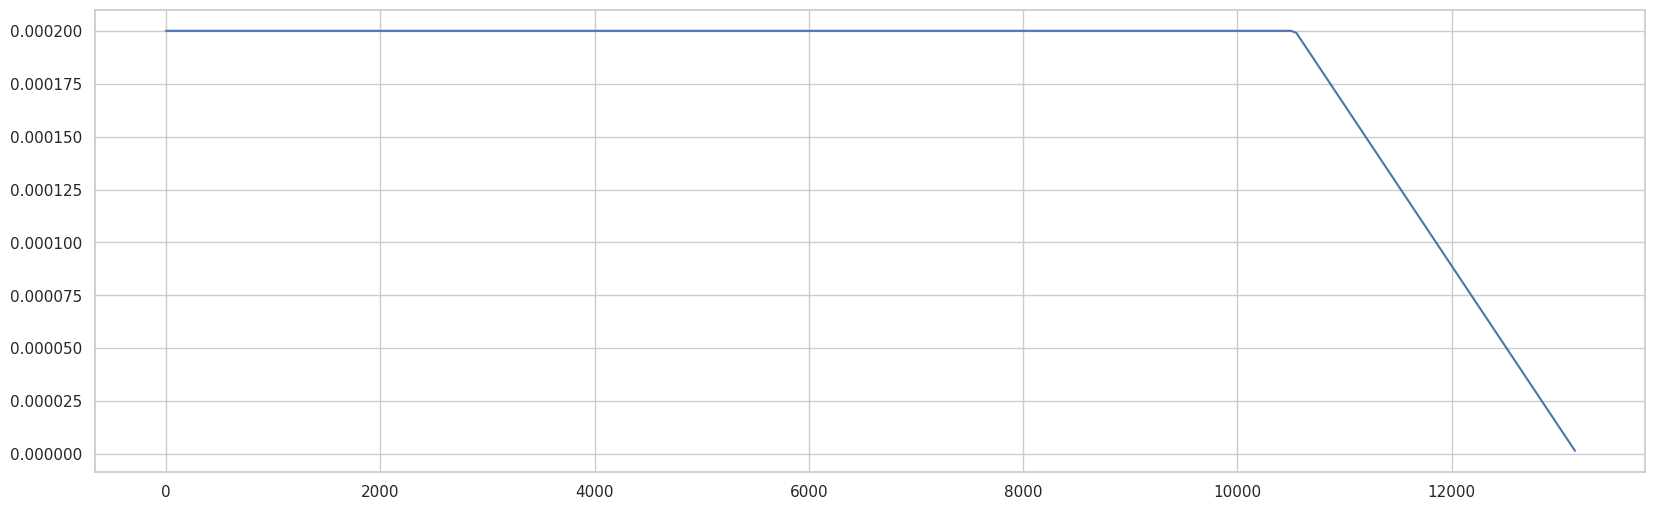

In [21]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.

    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8

    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Train

In [22]:
with tf.device('/GPU:0'):
  # Create generators
  lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
  lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))

  monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
  photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

  # Create discriminators
  lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
  lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))

  monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
  photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)


  # Create GAN
  gan_model = CycleGan(monet_generator, photo_generator,
                      monet_discriminator, photo_discriminator)

  gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                    p_gen_optimizer=photo_generator_optimizer,
                    m_disc_optimizer=monet_discriminator_optimizer,
                    p_disc_optimizer=photo_discriminator_optimizer,
                    gen_loss_fn=generator_loss,
                    disc_loss_fn=discriminator_loss,
                    cycle_loss_fn=calc_cycle_loss,
                    identity_loss_fn=identity_loss)

In [23]:
# Create dataset
#monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
#photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
#gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

#photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
#monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')

        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

In [ ]:
history = gan_model.fit(gan_ds,
                        epochs=EPOCHS,
                        callbacks=[GANMonitor()],
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE),
                        verbose=2).history

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node add_5 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 699, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 750, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 824, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 249, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 747, in __init__

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-24-89d7be85aeb3>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "<ipython-input-19-e68eb24eb8e3>", line 82, in train_step

  File "<ipython-input-20-345df00969df>", line 8, in discriminator_loss

required broadcastable shapes
	 [[{{node add_5}}]] [Op:__inference_multi_step_on_iterator_89056]

We can see the generators progress at each epoch by creating a `gif` that is a generated image at each epoch.

## Monet generation GIF

In [ ]:
# Got the idea from https://www.kaggle.com/matkneky/monet-cyclegan-trials
# Create GIFs
create_gif('/kaggle/working/monet/*.png', 'monet.gif') # Create monet gif

<img src='monet.gif' width=350>

## Photo generation GIF

In [ ]:
create_gif('/kaggle/working/photo/*.png', 'photo.gif') # Create photo gif

<img src='photo.gif' width=350>

# Evaluating generator models

Here we are going to evaluate the generator models including how good is the generator cycle, this means that we will get a photo to generate a Monet picture from it, then use the generated picture to generate the original photo.

## Photo (input) -> Monet (generated) -> Photo (generated)

In [ ]:
evaluate_cycle(photo_ds_eval.take(2), monet_generator, photo_generator, n_samples=2)

Here we will do the same process but starting with a Monet picture.

## Monet (input) -> Photo (generated) -> Monet (generated)

In [ ]:
evaluate_cycle(monet_ds_eval.take(2), photo_generator, monet_generator, n_samples=2)

# Visualize predictions

A common issue with images generated by GANs is that the often show some undisered artifacts, a very common on is known as "[checkerboard artifacts](https://distill.pub/2016/deconv-checkerboard/)", a good practice is to inspect some of the images to see its quality and if some of these undisered artifacts are present.

In [ ]:
display_generated_samples(photo_ds_eval.take(8), monet_generator, 8)

## Make predictions

In [ ]:
%%time
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(photo_ds_eval, monet_generator, '../images/')

# Submission file

In [ ]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

## Output models

In [ ]:
monet_generator.save('monet_generator.weights.h5')
photo_generator.save('photo_generator.weights.h5')
monet_discriminator.save('monet_discriminator.weights.h5')
photo_discriminator.save('photo_discriminator.weights.h5')